In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.axisbelow'] = True
plt.rcParams.update({'figure.autolayout': True})

import warnings
warnings.filterwarnings("ignore")

In [2]:
subway = pd.read_csv('ttc_subway_srt.csv')
weather = pd.read_csv('weather.csv')
holidays = pd.read_csv('holidays.csv')
locations = pd.read_csv('subway_location.csv')

In [3]:
#subway.sample(10)

In [4]:
subway['Date'] = pd.to_datetime(subway['Date'])
weather['Date/Time'] = pd.to_datetime(weather['Date/Time'])
holidays['date'] = pd.to_datetime(holidays['date'])

weather = weather.rename(columns={
    'Date/Time': 'Date', 
    'Mean Temp (°C)': 'Mean Temp', 
    'Total Precip (mm)': 'Precipitation'
})

holidays = holidays.rename(columns={
    'date': 'Date'
})

subway['Month'] = subway['Date'].dt.month
subway['nDay'] = subway['Date'].dt.day

weather = weather.drop(columns=['Year', 'Month', 'Day'])

subway = pd.merge(subway, weather, on='Date', how='left')
subway = pd.merge(subway, holidays, on='Date', how='left')

subway['holiday'] = subway['holiday'].fillna('None')

subway['Line'] = subway['Line'].replace({
    'B/D': 'BD', 
    'YU/ BD': 'YU/BD', 
    'YU / BD': 'YU/BD', 
    'BD LINE': 'BD', 
    'BD/YU': 'YU/BD', 
    'BD/YUS': 'YU/BD', 
    'YUS': 'YU', 
    'YU-BD': 'YU/BD', 
    'YU & BD': 'YU/BD', 
    'YU - BD LINE': 'YU/BD', 
    'YU BD': 'YU/BD',
    'YU LINE': 'YU',
    'BLOOR DANFORTH': 'BD',
    'YONGE UNIVERSITY SERVI': 'YU',
    'SHEPPARD': 'SHP',
    '25 DON MILLS': 'SHP',
    'YUBD': 'YU/BD',
    'YU - BD': 'YU/BD',
    '66': 'YU/BD'
})

subway['Precipitation'] = subway['Total Rain (mm)'] + (subway['Total Snow (cm)']*10)

In [ ]:
#subway.to_csv('subway_master.csv')

In [ ]:
subway.sample(5)

In [ ]:
weather.sample(5)

In [ ]:
holidays.sample(5)

In [ ]:
locations.sample(5)

In [ ]:
subway.info()

In [ ]:
weather.info()

In [ ]:
holidays.info()

<center><h2>Subway Delay Descriptives</h2></center>

In [18]:
groupedbyday = subway.groupby(['Date', 'Day']).agg({'Min Delay': 'sum'}).reset_index()

totaldays = len(groupedbyday)
totalmin = groupedbyday['Min Delay'].sum()
meanminperday = round(groupedbyday['Min Delay'].mean(), 2)
medianperday = round(groupedbyday['Min Delay'].median(), 2)
daysdelay = round((groupedbyday['Min Delay'].sum()/60)/24, 2)
percdelay = round(daysdelay / totaldays, 2)
sigmaday = round(groupedbyday['Min Delay'].std(), 2)
delayvariance = round(sigmaday ** 2, 2)

delaystats_dict = {
    'Total Days': totaldays,
    'Total Minutes': totalmin,
    'Days Delayed': daysdelay,
    'Mean Min. per Day': meanminperday,
    'Median Min. per Day': medianperday,
    '% of Days Delayed': percdelay,
    'Daily Sigma': sigmaday,
    'Delay Variance': delayvariance
}

delaystats = pd.DataFrame(delaystats_dict, index=['Stats'])
delaystats_export = pd.DataFrame(delaystats_dict, index=['Stats'])

delaystats = delaystats.style.format({
    '% of Days Delayed': '{:.2%}'.format
})

delaystats_export.to_csv('Subway Delay Stats.csv')
delaystats

,Total Days,Total Minutes,Days Delayed,Mean Min. per Day,Median Min. per Day,% of Days Delayed,Daily Sigma,Delay Variance
Stats,1946,216403,150.28,111.2,97,8.00%,74.96,5619


<center><h2>Latitude and Longitude Mapping of Delay Events - Subway</center></h2>

In [6]:
geo = locations.groupby('Station').agg({
    'subway_latitude': 'mean', 
    'subway_longitude': 'mean',
    'Code': 'count'
})

geo = geo.rename(columns={'Min Delay': 'Min Mean'})

geo = geo[geo['subway_latitude'] > 0].reset_index()

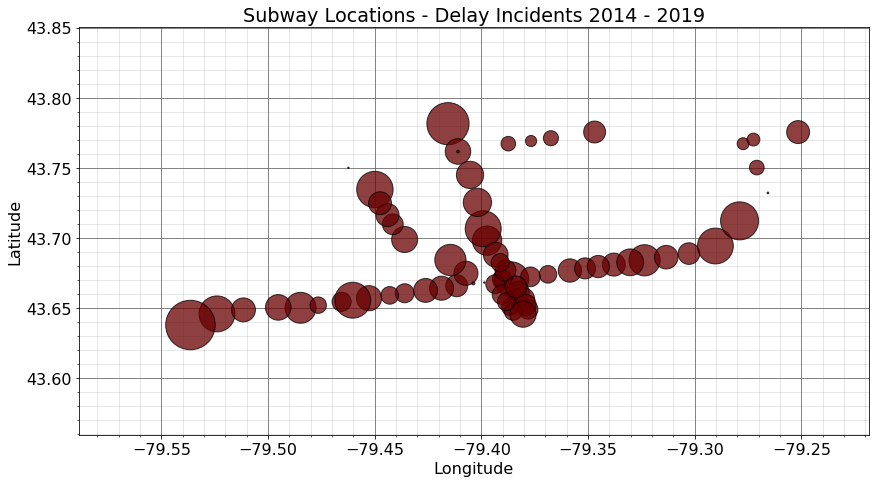

In [13]:
fig, ax = plt.subplots(1, figsize = [12.5, 7])

ax.scatter(
    geo['subway_longitude'], 
    geo['subway_latitude'], 
    c = '#680000', 
    s = geo['Code']/2,
    alpha = 0.75,
    edgecolor = 'black'
)

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_title('Subway Locations - Delay Incidents 2014 - 2019')

plt.grid(which = 'major', color = '#666666', linestyle = '-')
plt.minorticks_on()
plt.grid(which = 'minor', color = '#666666', linestyle = '-', alpha = 0.2)

plt.tight_layout()

plt.savefig('Subway Locations - Delay Incidents 2014 - 2019')
plt.show()

In [16]:
station_events = geo[['Station', 'Code']].sort_values('Code', ascending = False).head(25)
station_events.to_csv('Subway Station Delay Incidents Top 25.csv')
station_events.head(25)

,Station,Code
31,KIPLING STATION,4900
22,FINCH STATION,3562
62,WARDEN STATION,2896
64,WILSON STATION,2655
19,EGLINTON STATION,2591
26,ISLINGTON STATION,2582
28,KEELE STATION,2580
61,VICTORIA PARK STATION,2566
4,BLOOR STATION,2404
56,ST CLAIR WEST STATION,1957


<center><h2>Weather and the Subway</center></h2>

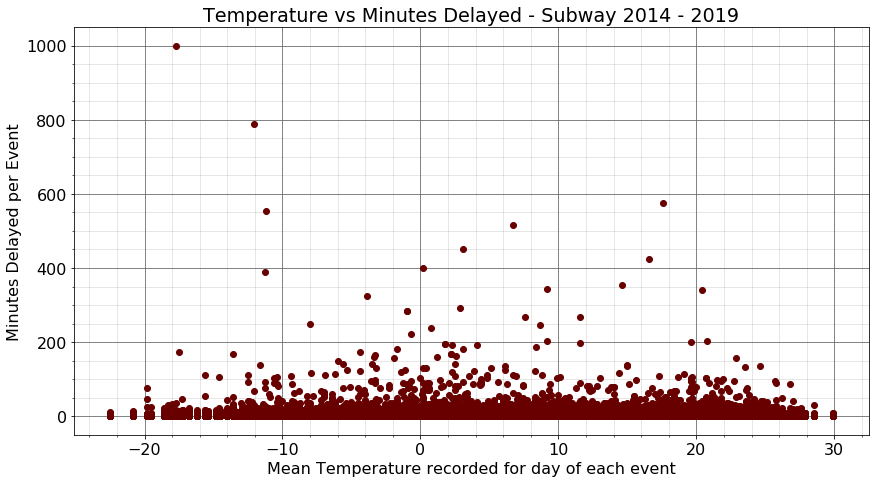

In [37]:
fig, ax = plt.subplots(1, figsize = [12.5, 7])

ax.scatter(
    subway['Mean Temp'], 
    subway['Min Delay'], 
    color = '#680000'
)

ax.set_ylabel('Minutes Delayed per Event')
ax.set_xlabel('Mean Temperature recorded for day of each event')
ax.set_title('Temperature vs Minutes Delayed - Subway 2014 - 2019')

plt.grid(which = 'major', color = '#666666', linestyle = '-')
plt.minorticks_on()
plt.grid(which = 'minor', color = '#666666', linestyle = '-', alpha = 0.2)

plt.tight_layout()
plt.savefig('Temperature vs Minutes Delayed - Subway 2014 - 2019')

plt.show()

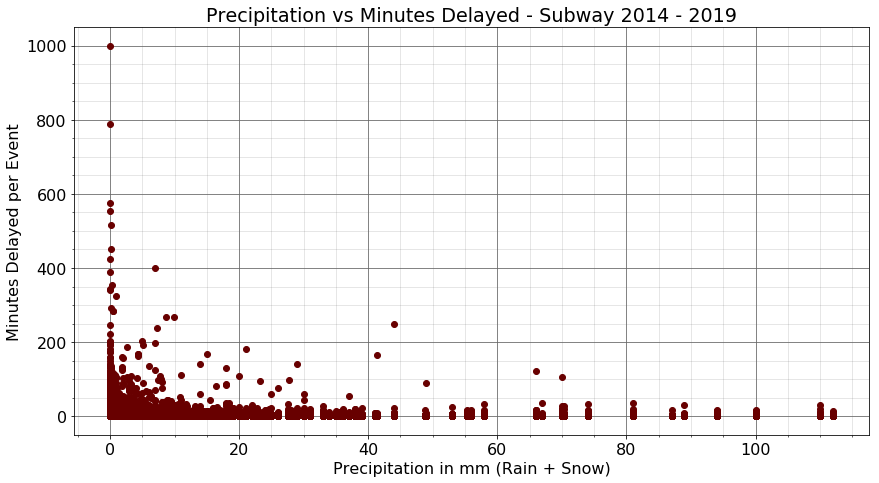

In [38]:
fig, ax = plt.subplots(1, figsize = [12.5, 7])

ax.scatter(
    subway['Precipitation'], 
    subway['Min Delay'], 
    color = '#680000'
)

ax.set_ylabel('Minutes Delayed per Event')
ax.set_xlabel('Precipitation in mm (Rain + Snow)')
ax.set_title('Precipitation vs Minutes Delayed - Subway 2014 - 2019')

plt.grid(which = 'major', color = '#666666', linestyle = '-')
plt.minorticks_on()
plt.grid(which = 'minor', color = '#666666', linestyle = '-', alpha = 0.2)

plt.tight_layout()
plt.savefig('Precipitation vs Minutes Delayed - Subway 2014 - 2019')

plt.show()

<center><h2>Visualizing Delays</center></h2>

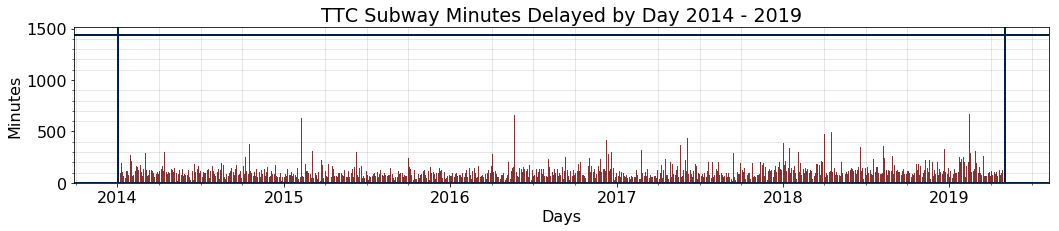

In [44]:
x = groupedbyday['Date']
y = groupedbyday['Min Delay']

fig, ax = plt.subplots(1, figsize = [15, 3.5])

ax.bar(
    x,
    y, 
    color = '#680000', 
    alpha = .8
)

ax.axhline(
    y = 1440, 
    color = '#002147',
    lw = 2
)

ax.axhline(
    y = 0, 
    color = '#002147', 
    lw = 2
)

ax.axvline(
    x = groupedbyday.iloc[0, 0], 
    color = '#002147', 
    lw = 2
)

ax.axvline(
    x = groupedbyday.iloc[1945, 0], 
    color = '#002147', 
    lw = 2
)

ax.set_ylabel('Minutes')
ax.set_xlabel('Days')
ax.set_title('TTC Subway Minutes Delayed by Day 2014 - 2019')

plt.minorticks_on()
plt.grid(b = True, which = 'minor', color = '#666666', linestyle = '-', alpha = 0.2)

plt.tight_layout()
plt.savefig('TTC_Subway_Mintues_Delayed_2014_2019.png')
plt.show()

Each x marker bar is representative of 1 day for a total of 1946 days. 1440 minutes are available in each day, so think of the space within the interior of the red box as time, with the dark blue bars of each delay as the amount of space in time the delays took.

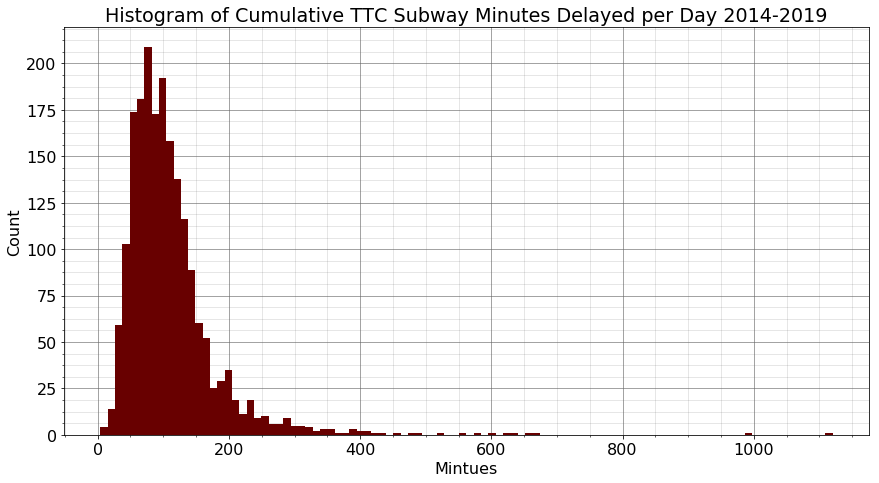

In [46]:
fig, ax = plt.subplots(1, figsize = [12.5, 7])

ax.hist(
    groupedbyday['Min Delay'], 
    bins = 100, 
    color = '#680000'
)

ax.set_xlabel('Mintues')
ax.set_ylabel('Count')
ax.set_title('Histogram of Cumulative TTC Subway Minutes Delayed per Day 2014-2019')

plt.grid(
    b = True, 
    which = 'major', 
    color = '#666666', 
    linestyle = '-',
    alpha = 0.75
)

plt.minorticks_on()
plt.grid(
    b = True, 
    which = 'minor', 
    color = '#666666', 
    linestyle = '-', 
    alpha = 0.2
)

plt.tight_layout()
plt.savefig('Histogram of Cumulative TTC Subway Minutes Delayed per Day 2014 - 2019.png')

plt.show()

<center><h2>Time of Day - Incident Counts</center></h2>

In [23]:
timeofday = subway.groupby(['Day', 'Time']).agg({'Min Delay': 'sum'}).reset_index()
timeofday['Time'] = pd.to_datetime(timeofday['Time'].str.strip(), format='%H:%M')
dailyincidents = subway.groupby(['Day', 'Time']).agg({'Min Delay': 'count'}).reset_index()
dailyincidents = dailyincidents.rename(columns={'Min Delay': 'Counts'})
timeofday['Counts'] = dailyincidents['Counts']
timeofday['Time'] = timeofday['Time'].dt.hour
timeofday = timeofday.groupby(['Day', 'Time']).agg({'Min Delay': 'sum', 'Counts': 'sum'}).reset_index().reset_index()
timeofday = timeofday.rename(columns={'index': 'Chronological'})

timeofday.head(10)

,Chronological,Day,Time,Min Delay,Counts
0,0,Friday,0,1552,503
1,1,Friday,1,1008,447
2,2,Friday,2,75,157
3,3,Friday,3,25,50
4,4,Friday,4,5,60
5,5,Friday,5,1054,497
6,6,Friday,6,1813,1138
7,7,Friday,7,1690,948
8,8,Friday,8,1703,1049
9,9,Friday,9,1467,857


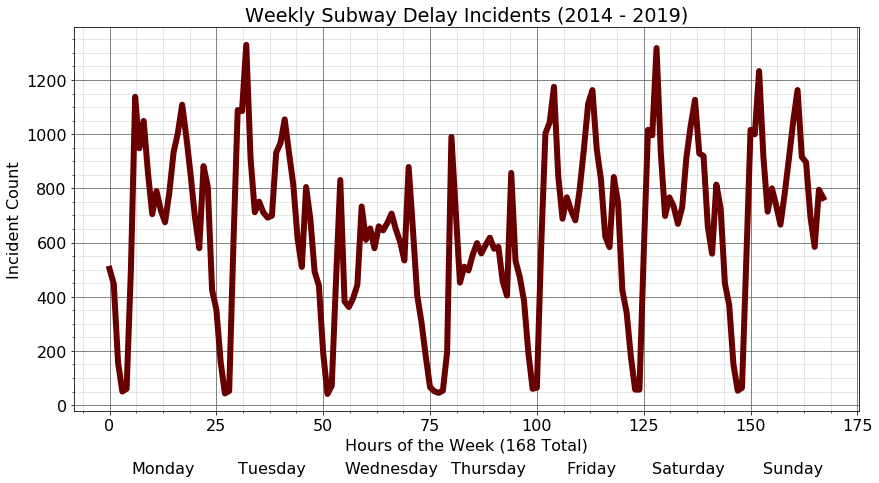

In [47]:
fig, ax = plt.subplots(1, figsize = [12.5, 7])

ax.plot(
    timeofday['Chronological'], 
    timeofday['Counts'], 
    color = '#680000', 
    lw = 6
)

ax.set_ylabel('Incident Count')
ax.set_xlabel('Hours of the Week (168 Total)')
ax.set_title('Weekly Subway Delay Incidents (2014 - 2019)')

plt.grid(which = 'major', color = '#666666', linestyle = '-')
plt.minorticks_on()
plt.grid(which = 'minor', color = '#666666', linestyle = '-', alpha = 0.2)

plt.text(5, -250, 'Monday')
plt.text(30, -250, 'Tuesday')
plt.text(55, -250, 'Wednesday')
plt.text(80, -250, 'Thursday')
plt.text(107, -250, 'Friday')
plt.text(127, -250, 'Saturday')
plt.text(153, -250, 'Sunday')

plt.tight_layout()
plt.savefig('Line Graph of Weekly Subway Delay Incidents (2014 - 2019).png')

plt.show()

<center><h2>Incidents</h2></center>

In [22]:
descriptions = pd.DataFrame(subway['Description'].value_counts()).reset_index().rename(columns={'index': 'Description', 'Description': 'Count'}).reset_index()
#descriptions['Count Order'] = np.arange(1, len(descriptions['Description']))
descriptions.head(25)

,index,Description,Count
0,0,Miscellaneous Speed Control,17720
1,1,Operator Overspeeding,12884
2,2,Passenger Assistance Alarm Activated - No Trou...,7307
3,3,Injured or ill Customer (In Station) - Transpo...,6640
4,4,Miscellaneous Other,5038
5,5,Miscellaneous General Delays,4952
6,6,Disorderly Patron,4398
7,7,Injured or ill Customer (On Train) - Medical A...,3459
8,8,Injured or ill Customer (On Train) - Transported,2849
9,9,Operator Violated Signal,2584


In [ ]:
#value_counts.to_csv('subway_description_value_counts.csv')
value_counts.head()

In [13]:
groupedmindelay = subway.groupby('Description').agg({
    'Min Delay': 'sum'
}).reset_index().rename(
    columns={'Min Delay': 'Minutes'
            })

groupedmindelay.sort_values('Minutes', ascending = False).head(20)

value_counts = subway.groupby('')

,Description,Minutes
46,Injured or ill Customer (On Train) - Transported,16523
21,Disorderly Patron,14774
35,Fire/Smoke Plan B - Source TTC,12905
45,Injured or ill Customer (On Train) - Medical A...,11715
72,Priority One - Train in Contact With Person,10533
24,Door Problems - Faulty Equipment,9199
129,Unauthorized at Track Level,7799
71,Passenger Other,6078
55,Miscellaneous Other,5494
70,Passenger Assistance Alarm Activated - No Trou...,5429


In [14]:


delays = pd.merge(value_counts, groupedmindelay, on='Description', how='left')
delays['Min per Incident'] = round(delays['Minutes'] / delays['# of Incidents'], 3)

NameError: name 'value_counts' is not defined

In [ ]:
delays.head(10)

In [ ]:
x = delays[delays['# of Incidents'] < 2000]
x = x[x['Minutes'] < 2000]
x = x.sort_values('Minutes').head(25)

In [ ]:
fig, ax = plt.subplots(1, figsize = [12.5, 7])

ax.scatter(
    x['# of Incidents'], 
    x['Minutes'],
    c = x['Min per Incident'],
    alpha = .5,
    s = 150
)

ax.set_xlabel('# of Incidents')
ax.set_ylabel('Minutes')
ax.set_title('Exploring Incidents and Time')

plt.show()

In [ ]:
x

In [ ]:
list(x.columns)

In [ ]:
bar1 = x['# of Incidents']
bar2 = x['Minutes']
bar3 = x['Min per Incident']

label = x['Description']
barwidth = 1
names = list(x.columns)

bars = np.add(bar1, bar2).tolist()

fig, ax = plt.subplots(1, figsize = [12.5, 10])

ax.bar(label, bar1, color='#002147', edgecolor='white', width=barwidth)
ax.bar(label, bar2, bottom=bar1, color='#5F90B2', edgecolor='white', width=barwidth)
ax.bar(label, bar3, bottom=bars, color='#848482', edgecolor='white', width=barwidth)

plt.xticks(label, names, fontweight='bold')
ax.set_xlabel('Description')

plt.show()

<center><h2>Stations</center></h2>

In [ ]:
stations = subway.groupby('Station').agg({
    'Min Delay': 'sum', 
}).rename(
    columns={
        'Min Delay': 'Sum', 
    })

stations = round(stations[stations['Sum'] > 0], 2)

In [ ]:
stations = stations.dropna().reset_index()
len(stations)

In [ ]:
fig, ax = plt.subplots()

ax.barh(stations['Station'], stations['Sum'])

In [ ]:
stations.sort_values('Sum', ascending = False).head()

<center><h2>Days of the Week</center></h2>

In [ ]:
subway.sample(5)

In [ ]:
weekdays = subway.groupby('Day').agg({
    'Min Delay': 'sum', 
    'Min Gap': 'sum',
    'Code': 'count'
}).rename(
    columns={'Min Delay': 'Sum of Minutes', 'Min Gap': 'Sum of Gap Minutes', 'Code': 'Incident Count'}).reset_index()
weekdays

In [ ]:
bar1 = weekdays['Min Delay']
bar2 = weekdays['Min Gap']

label = weekdays['Day']
barwidth = 1
names = weekdays['Day'].unique().tolist()
dayorder = [1, 5, 6, 4, 0, 2, 3]
names = [names[i] for i in dayorder]

bars = np.add(bar1, bar2).tolist()

fig, ax = plt.subplots(1, figsize = [12.5, 10])

p1 = ax.bar(label, bar1, color='#800000', edgecolor='white', width=barwidth)
p2 = ax.bar(label, bar2, bottom=bar1, color='#888888', edgecolor='white', width=barwidth)

ax.set_ylabel('Minutes')
ax.set_xlabel('Days of the Week')
ax.set_title('Subway Minutes Delayed per Day of the Week (2014 - Apr. 2019)')

plt.legend((p1[0], p2[0]), ('Minutes Delayed', 'Gap in Minutes'))

plt.xticks(label, names)

plt.minorticks_on()
plt.grid(
    b = True, 
    which = 'minor', 
    color = '#666666', 
    linestyle = '-', 
    alpha = 0.2
)

plt.tight_layout()

plt.savefig('Subway Minutes Delayed per Day of the Week.png')
plt.show()

In [ ]:
subway.head()

In [16]:
timeofday.head(10)

,Chronological,Day,Time,Min Delay,Counts
0,0,Friday,0,1552,503
1,1,Friday,1,1008,447
2,2,Friday,2,75,157
3,3,Friday,3,25,50
4,4,Friday,4,5,60
5,5,Friday,5,1054,497
6,6,Friday,6,1813,1138
7,7,Friday,7,1690,948
8,8,Friday,8,1703,1049
9,9,Friday,9,1467,857


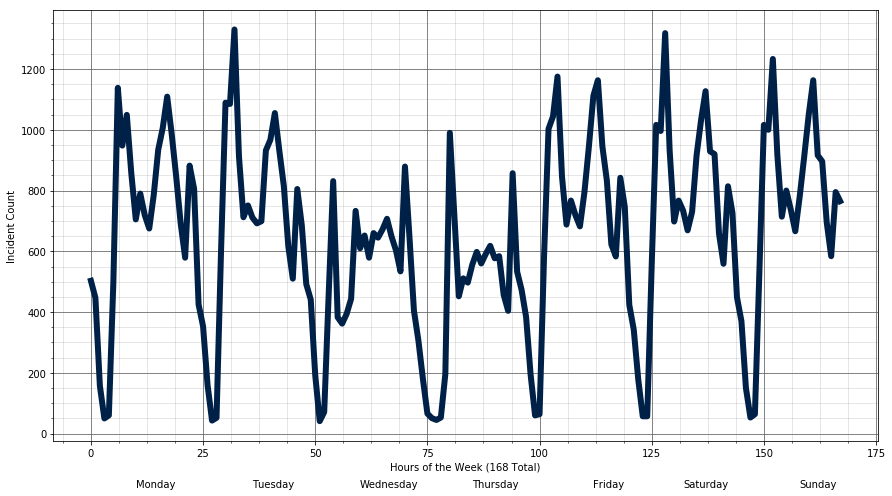

<center><h2>By Line</h2></center>

In [ ]:
subway['Line'].value_counts()

In [31]:
line = subway.groupby(['Date', 'Day', 'Line']).agg({'Min Delay': 'sum', 'Code': 'count'}).reset_index()
line = line[line['Min Delay'] > 0]
line = round(line.groupby(['Day', 'Line']).agg({'Min Delay': 'median', 'Code': 'mean'}), 2).reset_index()
line = line.rename(columns={'Min Delay': 'Median Minutes Delayed per Day', 'Code': 'Median # of Incidents per Day'})
line['Median Incident Length'] = round(line['Median Minutes Delayed per Day'] / line['Median # of Incidents per Day'], 2)
line['Combined'] = line['Day'] + ' ' + line['Line']

In [32]:
line.head()

,Day,Line,Median Minutes Delayed per Day,Median # of Incidents per Day,Median Incident Length,Combined
0,Friday,BD,44.0,29.26,1.50,Friday BD
1,Friday,SHP,5.5,2.69,2.04,Friday SHP
2,Friday,SRT,10.0,3.15,3.17,Friday SRT
3,Friday,YU,45.0,27.32,1.65,Friday YU
4,Monday,BD,41.0,28.55,1.44,Monday BD


In [33]:
monday = line[line['Day'] == 'Monday']
tuesday = line[line['Day'] == 'Tuesday']
wednesday = line[line['Day'] == 'Wednesday']
thursday = line[line['Day'] == 'Thursday']
friday = line[line['Day'] == 'Friday']
saturday = line[line['Day'] == 'Saturday']
sunday = line[line['Day'] == 'Sunday']


In [34]:
sunday

,Day,Line,Median Minutes Delayed per Day,Median # of Incidents per Day,Median Incident Length,Combined
13,Sunday,BD,23.0,17.45,1.32,Sunday BD
14,Sunday,SHP,6.0,2.54,2.36,Sunday SHP
15,Sunday,SRT,8.0,2.46,3.25,Sunday SRT
16,Sunday,YU,25.5,17.63,1.45,Sunday YU


TypeError: unsupported operand type(s) for +: 'DatetimeIndex' and 'float'

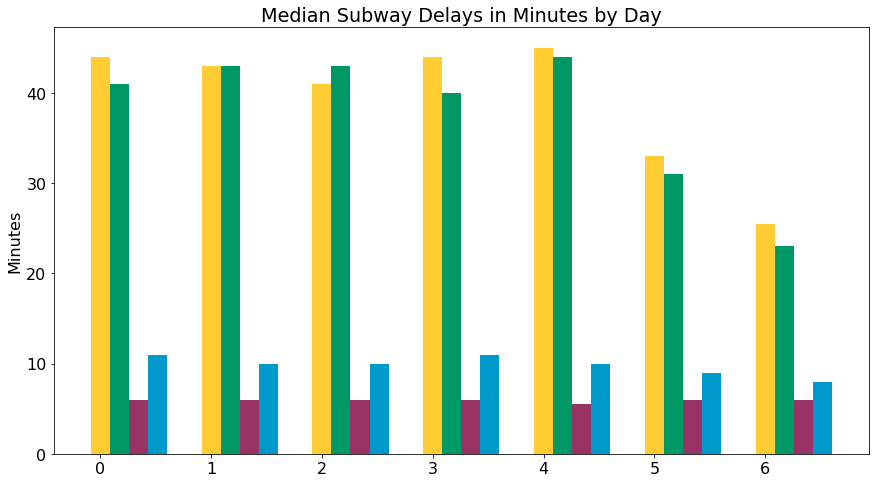

In [36]:
labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
yu_medians = [44, 43, 41, 44, 45, 33, 25.5]
bd_medians = [41, 43, 43, 40, 44, 31, 23]
shp_medians = [6, 6, 6, 6, 5.5, 6, 6]
srt_medians = [11, 10, 10, 11, 10, 9, 8]

width = 0.172
r1 = np.arange(len(labels))
r2 = [x + width for x in r1]
r3 = [x + width for x in r2]
r4 = [x + width for x in r3]


fig, ax = plt.subplots(figsize = [12.5, 7])
bar1 = ax.bar(r1, yu_medians, width, color='#FFCC33', label='Yonge/University')
bar2 = ax.bar(r2, bd_medians, width, color='#009966', label='Bloor/Danforth')
bar3 = ax.bar(r3, shp_medians, width, color='#993366', label='Sheppard')
bar4 = ax.bar(r4, srt_medians, width, color='#0099cc', label='Scarborough RT')


ax.set_ylabel('Minutes')
ax.set_title('Median Subway Delays in Minutes by Day')
ax.set_xticks(x + .25)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.savefig('side by side bar charts.png')

plt.show()

In [ ]:
sunday

In [ ]:
labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
yu_incidents = [27.43, 27.66, 27.11, 27.58, 27.32, 20.45, 17.63]
bd_incidents = [28.55, 29.34, 30.09, 29.51, 29.26, 21.23, 17.45]
shp_incidents = [3.02, 2.77, 2.67, 2.97, 2.69, 2.77, 2.54]
srt_incidents = [3.05, 2.96, 3.3, 3.03, 3.15, 2.63, 2.46]

width = 0.172
r1 = np.arange(len(labels))
r2 = [x + width for x in r1]
r3 = [x + width for x in r2]
r4 = [x + width for x in r3]


fig, ax = plt.subplots(figsize = [12.5, 7])
bar1 = ax.bar(r1, yu_incidents, width, color='#FFCC33', label='Yonge/University')
bar2 = ax.bar(r2, bd_incidents, width, color='#009966', label='Bloor/Danforth')
bar3 = ax.bar(r3, shp_incidents, width, color='#993366', label='Sheppard')
bar4 = ax.bar(r4, srt_incidents, width, color='#0099cc', label='Scarborough RT')


ax.set_ylabel('Minutes')
ax.set_title('Median Subway Delay Incidents by Day')
ax.set_xticks(x + .25)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()